In [ ]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import io

# Specify the file name
zip_file_name = "archive (1).zip"

# Unzip the file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall("fer2013")


In [ ]:
import os

# List files in the directory
dataset_dir = "fer2013/train"
os.listdir(dataset_dir)


['happy', 'neutral', 'surprise', 'fear', 'sad', 'disgust', 'angry']

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Path to the directory containing the train and test folders
train_data_dir = "fer2013/train/"
test_data_dir = "fer2013/test/"

# Function to load and preprocess images
def preprocess_images(data_dir, emotion_labels):
    images = []
    labels = []

    for emotion_label, emotion in enumerate(emotion_labels):
        emotion_folder = os.path.join(data_dir, emotion)
        for image_name in os.listdir(emotion_folder):
            image_path = os.path.join(emotion_folder, image_name)
            image = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
            image_array = img_to_array(image)
            image_data = image_array / 255.0  # Normalize pixel values to the range [0, 1]

            images.append(image_data)
            labels.append(emotion_label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(emotion_labels))  # One-hot encode labels

    return images, labels

IMG_HEIGHT=48
IMG_WIDTH = 48
batch_size=32

train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							test_data_dir,
							color_mode='grayscale',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)
img, label = train_generator.__next__()

# Define the emotion labels
emotion_labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# Load and preprocess training and test sets
train_images, train_labels = preprocess_images(os.path.join(train_data_dir), emotion_labels)
test_images, test_labels = preprocess_images(os.path.join(test_data_dir), emotion_labels)

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Display the shapes of the split sets
print("\nShapes of the Split Sets:")
print("Training set:", train_images.shape, train_labels.shape)
print("Validation set:", val_images.shape, val_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

Shapes of the Split Sets:
Training set: (22967, 48, 48, 1) (22967, 7)
Validation set: (5742, 48, 48, 1) (5742, 7)
Test set: (7178, 48, 48, 1) (7178, 7)


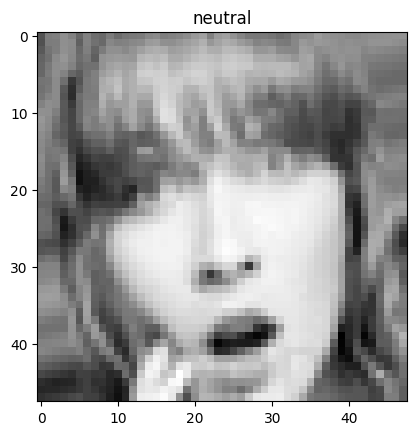

In [ ]:
import random
import matplotlib.pyplot as plt

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = emotion_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

Resnet 50

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Convert grayscale images to RGB by replicating the single channel to three channels
train_images_rgb = np.repeat(train_images, 3, axis=-1)
test_images_rgb = np.repeat(test_images, 3, axis=-1)

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images_rgb, train_labels, test_size=0.2, random_state=42
)

# Modify the create_resnet50_model function
def create_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output

    # Add Global Average Pooling layer
    x = GlobalAveragePooling2D()(x)

    # Add additional convolutional layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Add more dense layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Define input shape and number of classes
input_shape = (48, 48, 3)  # Assuming you are using color images now
num_classes = 7  # Number of emotion classes

# Create the model
resnet50_model = create_resnet50_model(input_shape, num_classes)

# Display the model summary
resnet50_model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
loss_function = CategoricalCrossentropy()
resnet50_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
# Set up callbacks for model saving and early stopping
checkpoint_path = "emotion_resnet_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and capture the history
history = resnet50_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

# Save the final model
resnet50_model.save("final_emotion_resnet_model.h5")

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


575/575 [==============================] - 87s 74ms/step - loss: 1.5856 - accuracy: 0.3913 - val_loss: 1.9238 - val_accuracy: 0.2262
Epoch 2/20
574/575 [============================>.] - ETA: 0s - loss: 1.4732 - accuracy: 0.4417
Epoch 2: val_loss improved from 1.92384 to 1.42012, saving model to emotion_resnet_model.h5
575/575 [==============================] - 43s 74ms/step - loss: 1.4731 - accuracy: 0.4417 - val_loss: 1.4201 - val_accuracy: 0.4519
Epoch 3/20
574/575 [============================>.] - ETA: 0s - loss: 1.4417 - accuracy: 0.4498
Epoch 3: val_loss did not improve from 1.42012
575/575 [==============================] - 37s 64ms/step - loss: 1.4417 - accuracy: 0.4498 - val_loss: 1.4901 - val_accuracy: 0.4066
Epoch 4/20
575/575 [==============================] - ETA: 0s - loss: 1.4436 - accuracy: 0.4470
Epoch 4: val_loss did not improve from 1.42012
575/575 [==============================] - 35s 62ms/step - loss: 1.4436 - accuracy: 0.4470 - val_loss: 1.7123 - val_accuracy: 0


Test Loss: 1.3931
Test Accuracy: 46.70%
225/225 [==============================] - 4s 12ms/step

Test Accuracy: 0.46698244636388964

Classification Report:
              precision    recall  f1-score   support

       angry       0.41      0.13      0.20       958
     disgust       0.00      0.00      0.00       111
        fear       0.20      0.05      0.08      1024
       happy       0.66      0.77      0.71      1774
         sad       0.30      0.49      0.37      1247
    surprise       0.60      0.66      0.63       831
     neutral       0.41      0.52      0.46      1233

    accuracy                           0.47      7178
   macro avg       0.37      0.38      0.35      7178
weighted avg       0.44      0.47      0.43      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


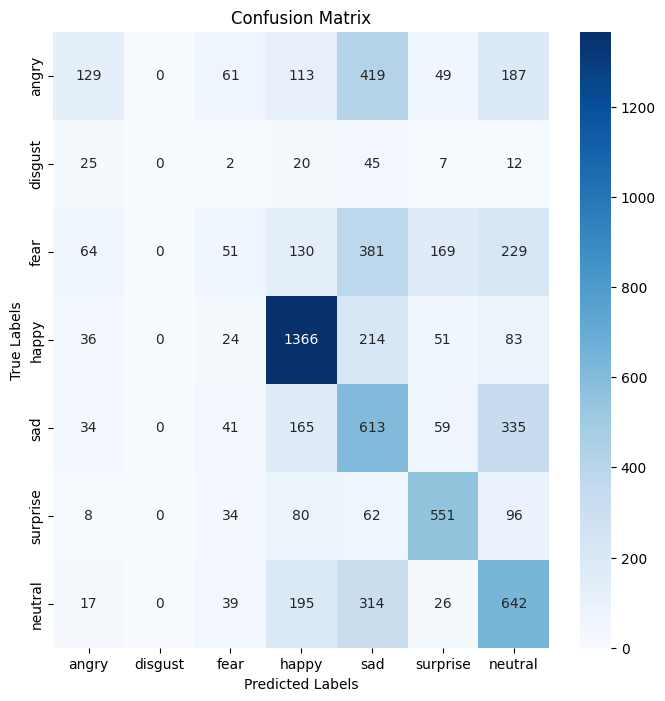

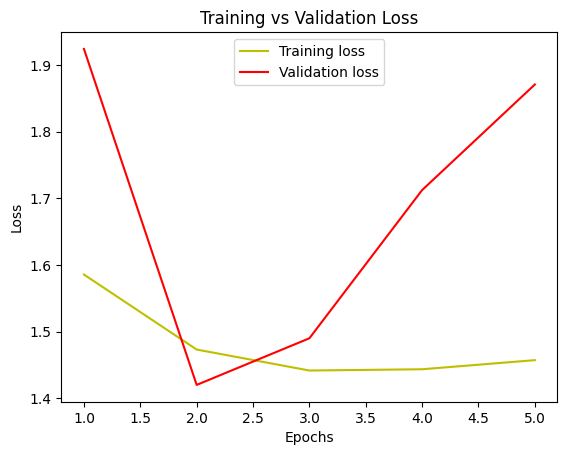

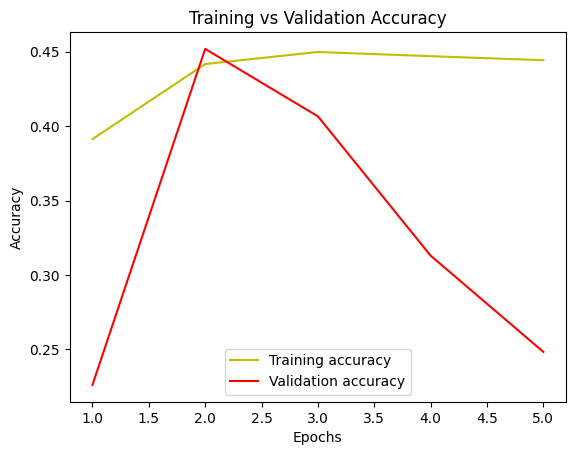

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best weights saved during training for ResNet-50 model
resnet50_model.load_weights("final_emotion_resnet_model.h5")

# Evaluate on the test set
test_loss, test_accuracy = resnet50_model.evaluate(test_images_rgb, test_labels, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions on the entire test set
test_img, test_lbl = validation_generator.__next__()
test_predictions = resnet50_model.predict(test_images_rgb)
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print("\nTest Accuracy:", test_accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

import matplotlib.pyplot as plt

# Define the number of epochs used during training
epochs = range(1, len(history.history['loss']) + 1)

# Plot the overall training and validation loss
plt.plot(epochs, history.history['loss'], 'y', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the overall training and validation accuracy
plt.plot(epochs, history.history['accuracy'], 'y', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


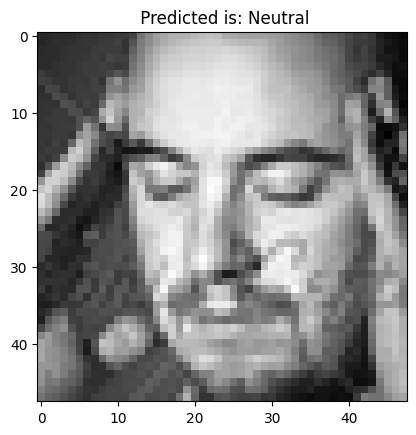

In [ ]:
true_labels_2 = np.argmax(test_lbl, axis=1)
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[true_labels_2[n]]
pred_labl = class_labels[predicted_labels[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
!pip install tf-keras-vis



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.3 MB/s eta 0:00:00


ResNet50 Model afer Improvement


Test Loss: 1.1079
Test Accuracy: 58.69%
225/225 [==============================] - 1s 4ms/step

Test Accuracy: 0.5869322931178601

Classification Report:
              precision    recall  f1-score   support

       angry       0.52      0.44      0.48       958
     disgust       0.63      0.29      0.40       111
        fear       0.44      0.36      0.40      1024
       happy       0.75      0.85      0.79      1774
         sad       0.46      0.42      0.44      1247
    surprise       0.75      0.72      0.73       831
     neutral       0.51      0.61      0.55      1233

    accuracy                           0.59      7178
   macro avg       0.58      0.53      0.54      7178
weighted avg       0.58      0.59      0.58      7178



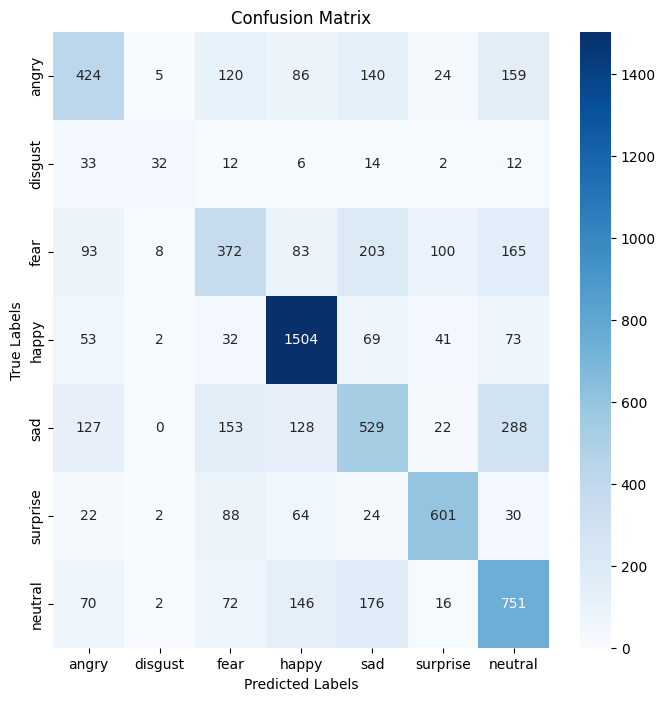

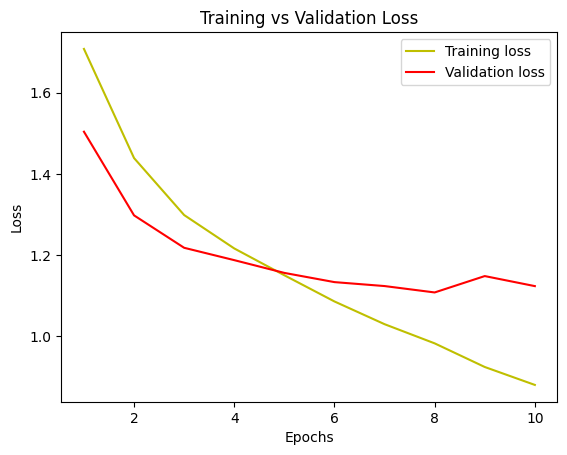

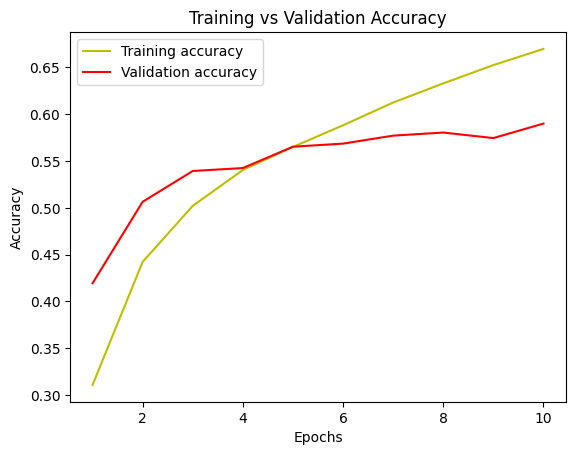

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best weights saved during training
vgg16_model.load_weights("final_emotion_model.h5")

# Extract the history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Evaluate on the test set
test_loss, test_accuracy = vgg16_model.evaluate(test_images, test_labels, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions on the entire test set
test_img, test_lbl = validation_generator.__next__()
test_predictions = vgg16_model.predict(test_images)
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)


# Accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print("\nTest Accuracy:", test_accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


import matplotlib.pyplot as plt

# Define the number of epochs used during training
epochs = range(1, len(history.history['loss']) + 1)

# Plot the overall training and validation loss
plt.plot(epochs, history.history['loss'], 'y', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the overall training and validation accuracy
plt.plot(epochs, history.history['accuracy'], 'y', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


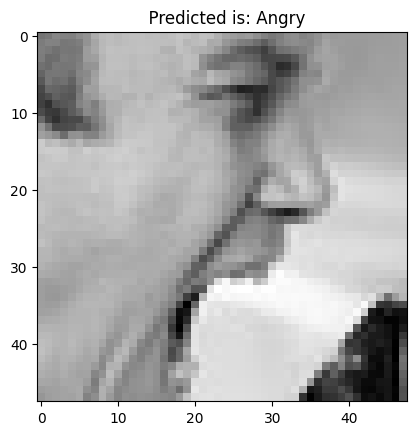

In [ ]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[true_labels[n]]
pred_labl = class_labels[predicted_labels[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("  Predicted is: "+ pred_labl)
plt.show()

In [ ]:
# Choose an image from the test set for which you want to generate CAM
img_path = 'fer2013/test/happy/PrivateTest_10077120.jpg'

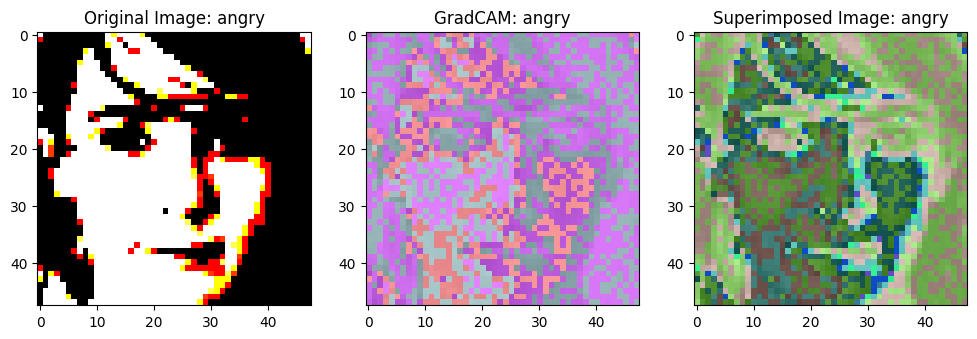

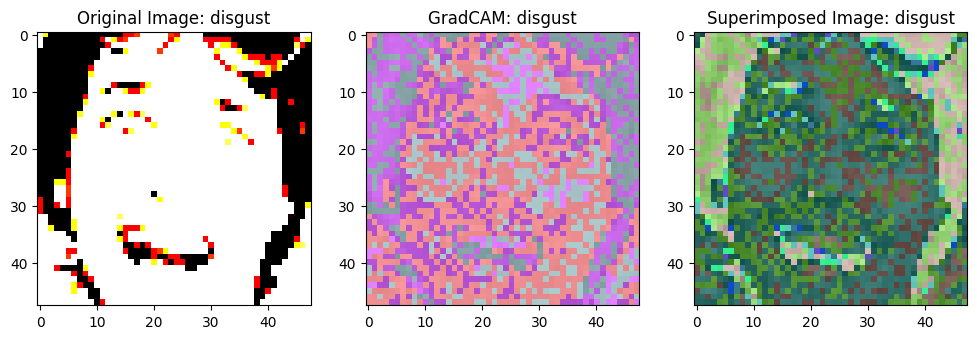

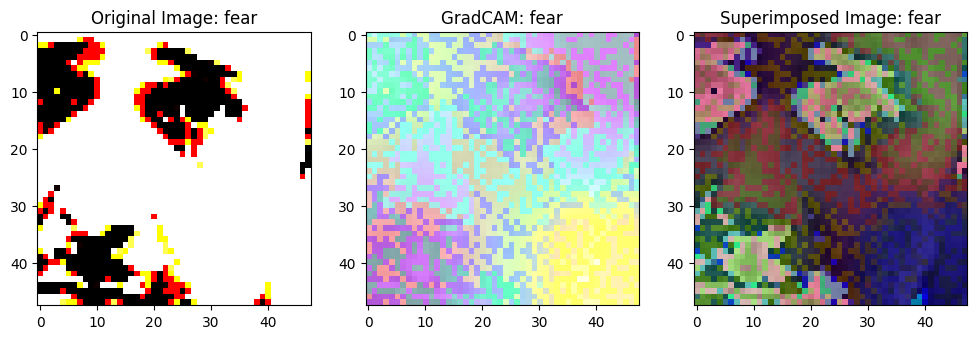

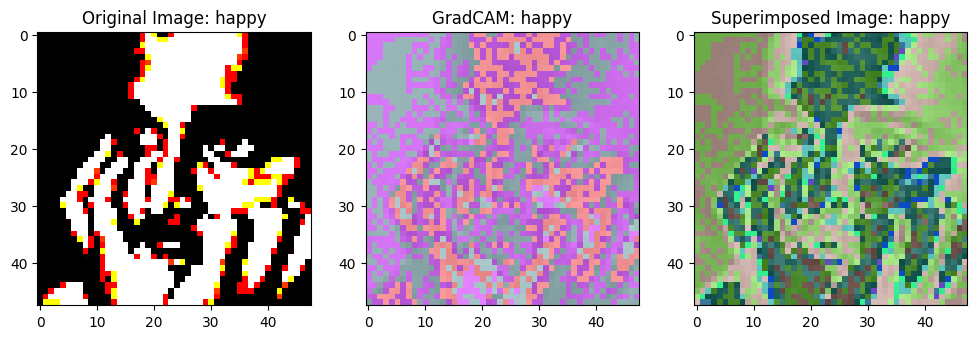

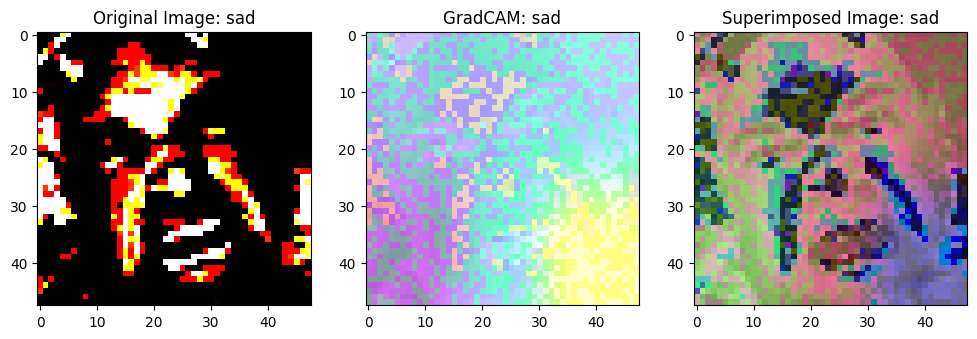

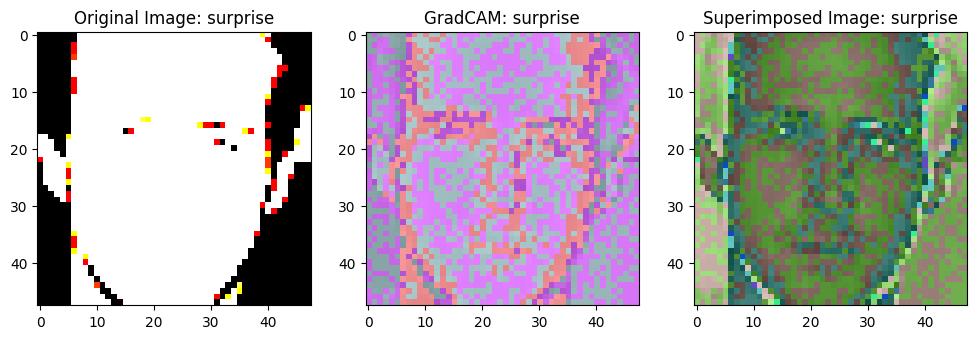

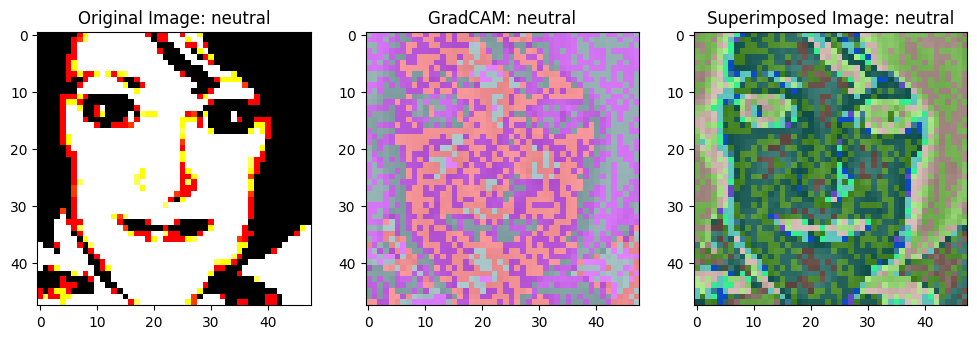

In [ ]:
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to generate CAM using tf-explain
def generate_cam_tf_explain(model, img_path, class_index=None):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Create an instance of GradCAM
    explainer = GradCAM()

    # Generate CAM
    grid = explainer.explain((img_array, None), model, class_index=class_index)

    # Resize the CAM to match the original image size
    cam = cv2.resize(grid, (img_array.shape[2], img_array.shape[1]))

    # Apply the CAM as an overlay on the original image
    cam_overlay = np.uint8(255 * cam)
    img_with_overlay = cv2.addWeighted(img_array[0].astype('uint8'), 0.5, cam_overlay, 0.5, 0)

    return img_array[0], cam, img_with_overlay

# Display original image, CAM image, and superimposed image for each class
for i, emotion in enumerate(emotion_labels):
    # Find index of the current class in the one-hot encoded labels
    class_index = np.argmax(test_lbl_batch[i])

    # Save the image temporarily to disk for tf-explain
    temp_img_path = f"temp_img_{i}.png"
    plt.imsave(temp_img_path, np.squeeze(test_img_batch[i], axis=-1), cmap='gray')

    # Generate CAM images
    original_img, cam_img, superimposed_img = generate_cam_tf_explain(resnet50_model, temp_img_path, class_index)

    # Display images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title(f"Original Image: {emotion}")

    plt.subplot(1, 3, 2)
    plt.imshow(cam_img, cmap='jet', alpha=0.7)
    plt.title(f"GradCAM: {emotion}")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Superimposed Image: {emotion}")

    plt.show()

    # Remove temporary image file
    os.remove(temp_img_path)
